In [59]:
import numpy as np
import matplotlib . pyplot as plt

In [60]:
def read_csv ( csv_path ):
    np_path_XYs = np . genfromtxt( csv_path , delimiter =',')
    path_XYs = []
    for i in np . unique ( np_path_XYs [: , 0]):
        npXYs = np_path_XYs [ np_path_XYs [: , 0] == i ][: , 1:]
        XYs = []
        for j in np . unique ( npXYs [: , 0]):
            XY = npXYs [ npXYs [: , 0] == j ][: , 1:]
            XYs . append ( XY )
        path_XYs . append ( XYs )
    return path_XYs


def plot ( path_XYs ):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 
    fig , ax = plt . subplots ( tight_layout = True , figsize =(8 , 8))
    for i , XYs in enumerate ( path_XYs ):
        c = colours [ i % len ( colours )]
        for XY in XYs :
            ax . plot ( XY [: , 0] , XY [: , 1] , c =c , linewidth =2)
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 250)
    plt . show ()
    
    
def plot_points(path_XYs):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.scatter(XY[:, 0], XY[:, 1], c=c, s=1) 
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 250)
    ax.set_xticks([0, 50, 100, 150, 200])
    ax.set_yticks([0, 50, 100, 150, 200])
    plt.show()

<class 'list'>
8


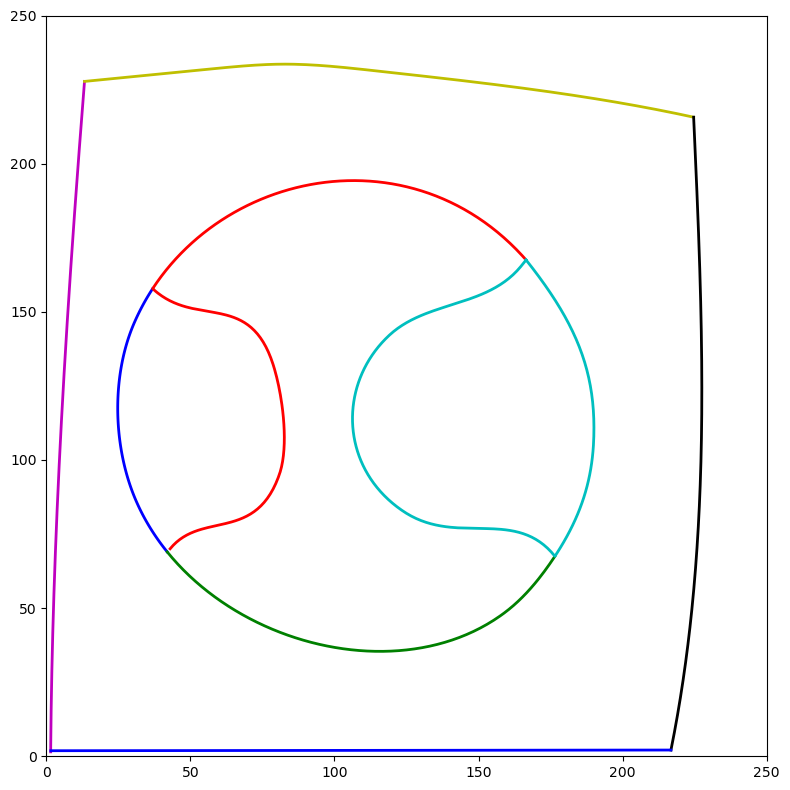

In [70]:
shape = read_csv("resources/frag1.csv")
print(type(shape))
print(len(shape))
shape
# plot([shape[0]])
plot(shape)

In [62]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from scipy.optimize import least_squares
from sklearn.preprocessing import StandardScaler

def detect_line(points_list,threshold = 0.1):
    # Extract the NumPy array from the list
    points = points_list[0]
    
    # Extract x and y values
    x = points[:, 0]
    y = points[:, 1]
    
    # Compute the line of best fit
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    # Compute distances from the line
    distances = np.abs(m * x - y + c) / np.sqrt(m**2 + 1)
    
    # Calculate the distance between the first and last points
    distance_between_first_last = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
    
    # Calculate 10% of that distance as the tolerance
    tolerance = threshold * distance_between_first_last

    # Check if the maximum distance is below the tolerance
    if np.max(distances) < tolerance:
        return True, m, c
    return False, None, None



def fit_circular_arc(points, tolerance=2):
    points = points[0]
    n_points = len(points)
    
    if n_points < 10:
        return False, None
    
    # Select 10% from start, middle, and end
    ten_percent = n_points // 10
    indices = np.concatenate([
        np.arange(ten_percent),
        np.arange(n_points//2 - ten_percent//2, n_points//2 + ten_percent//2),
        np.arange(n_points - ten_percent, n_points)
    ])
    selected_points = points[indices]
    
    x, y = selected_points[:, 0], selected_points[:, 1]
    
    # Function to find the center (cx, cy) and radius r
    def calculate_center(x, y):
        A = np.vstack([x, y, np.ones(len(x))]).T
        b = x**2 + y**2
        sol = np.linalg.lstsq(A, b, rcond=None)[0]
        cx, cy = sol[0] / 2, sol[1] / 2
        r = np.sqrt(sol[2] + cx**2 + cy**2)
        return cx, cy, r
    
    # Calculate the initial center and radius
    cx, cy, r = calculate_center(x, y)
    
    # Check the initial 30% points within the tolerance
    distances = np.sqrt((x - cx)**2 + (y - cy)**2)
    if np.all(np.abs(distances - r) <= tolerance):
        # Check the remaining 70% points
        rest_indices = np.setdiff1d(np.arange(n_points), indices)
        rest_points = points[rest_indices]
        rest_distances = np.sqrt((rest_points[:, 0] - cx)**2 + (rest_points[:, 1] - cy)**2)
        if np.all(np.abs(rest_distances - r) <= tolerance):
            return True, cx, cy
    
    return False, None, None


def compute_curvature_points(points_list,threshold = 0.35):
    points = points_list[0]
    points = np.array(points, dtype=float)  # Ensure the points are float type

    # Compute first derivatives
    dx_dt = np.gradient(points[:, 0])
    dy_dt = np.gradient(points[:, 1])

    # Compute second derivatives
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    # Compute the curvature
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5

    # Find indices with curvature greater than 0.35
    high_curvature_indices = np.where(curvature > threshold)[0]

    # Ensure the first and last indices are included
    high_curvature_indices = np.append(high_curvature_indices, [0, len(points) - 1])

    # Remove duplicates and sort indices
    high_curvature_indices = np.unique(high_curvature_indices)

    return high_curvature_indices
    
    
def split_points(points_list, high_curvature_indices):
    segments = []
    points = points_list[0]  # Extract the array from the nested list

    start_index = high_curvature_indices[0]

    for i in range(1, len(high_curvature_indices)):
        end_index = high_curvature_indices[i]
        # Check if the difference with the previous element is > 1
        if end_index - high_curvature_indices[i-1] > 1:
            segments.append(points[start_index:end_index + 1])
            start_index = end_index

    # Add the last segment
    if start_index < len(points):
        segments.append(points[start_index:])

    return [np.array(segment) for segment in segments[:-1]]  # Ensure each segment is an array



In [63]:
def process_shape(shape):
    new_shape = []
    for s in shape:
        high_curvature_indices = compute_curvature_points(s)
        if len(high_curvature_indices) > 2:
            segments = split_points(s, high_curvature_indices)  # Pass s in a list as expected by split_points
            for seg in segments:
                new_shape.append([seg])  # Append as a list of array to match original shape structure
        else:
            new_shape.append(s)  # Retain the original segment if no significant curvature points found

    return new_shape

# Example usage
print(len(shape))
shape = process_shape(shape)
print(len(shape))


line = []
circle = []
other = []
for s in shape:
    is_line, m, c = detect_line(s)
    if is_line:
        line.append(s)
    else:
        is_circle, cx, cy = fit_circular_arc(s)
        if is_circle:
            circle.append(s)
        else:
            other.append(s)
            
print(len(line))
print(len(circle))
print(len(other))

8
10
4
4
2


In [68]:
print(line[0][0][0])
print(line[0][0][len(line[0][0])-1])
print(line[1][0][0])
print(line[1][0][len(line[1][0])-1])
print(line[2][0][0])
print(line[2][0][len(line[2][0])-1])
print(line[3][0][0])
print(line[3][0][len(line[3][0])-1])

[ 13.24499989 227.75500488]
[1.5 1.5]
[224.64700317 215.67999268]
[ 13.24499989 227.75500488]
[216.7769928    2.10700011]
[224.64700317 215.67999268]
[1.56200004 1.87600005]
[216.77799988   2.10700011]
